# SNN Loss based on Neative L2 Distance

In this notebook, we'll see an example of how to use the SNN loss based on negative $L_2$ distance. We use the negative distance as the similarity function requires higher values for similar points.

We'll start with 6 random points, and by optimizing the SNN loss, we'll group them into groups of points, equally distributed in the space. Since the SNN loss encourages different groups to be far apart, the points will go to infinity in an unbounded space. Therefore, we'll use the $tanh$ function to bound the points in the range $[-1, 1]$ (any function to bound the points in a range will work).

First, let's import the `contrastive` library and the `torch` library. Notice that `torch` should be loaded before `contrastive` to avoid some errors.

In [1]:
import torch
import contrastive

We also import auxiliary libraries to help us with the visualization of the results:

In [2]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

We define the device to be used (GPU or CPU):

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We create a batch of 6 random points in 2D, and define the labels for the points - the first two points are positive examples, the next two are positive examples, and the last two are positive examples. The negative examples are the points that are not in the same group.

In [4]:
z = torch.randn(8, 2, requires_grad=True, device=device) # We require gradients to update the embeddings
labels = torch.tensor([0, 0, 1, 1, 2, 2, 3, 3], device=device)

We write a function that will plot the points and color them according to their labels:

In [5]:
def plot_points(z, labels):
    """ Plots the points, the color of a points represents its label"""
    plt.figure()
    plt.scatter(z[:, 0].detach().cpu().numpy(), z[:, 1].detach().cpu().numpy(), c=labels.cpu())
    max_x = z.detach().abs().max().item() * 1.1
    max_y = z.detach().abs().max().item() * 1.1
    plt.xlim(-max_x, max_x)
    plt.ylim(-max_y, max_y)
    plt.show()

And use it to plot the points:

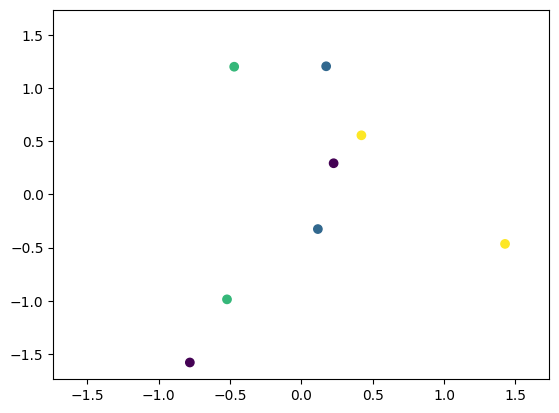

In [6]:
plot_points(z, labels)

Now, let's optimize the points to minimize the SNN loss function (notice we're using the negative $L_2$ distance as the similarity measure, by setting the `use_cosine` parameter to `False`):

In [7]:
# define the optimizer
optimizer = torch.optim.Adam([z], lr=1e-1)

# log the loss
losses = []

# optimize the points to minimize the loss
pbar = tqdm(range(1_000))
for i in pbar:
    optimizer.zero_grad()
    result = contrastive.snnl(tensor=z.tanh(), labels=labels, temperature=1, reduce="mean", use_cosine=False) # We use the tanh to ensure the embeddings are in the range [-1, 1]
    result.backward()
    optimizer.step()
    losses.append(result.item())
    if i % 100 == 0:
        pbar.set_postfix({"loss": f"{result.item():.4f}"})

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot the loss behavior during the optimization process. We expect the loss to decrease over time but not to reach zero, as the SNN loss has a lower bound:

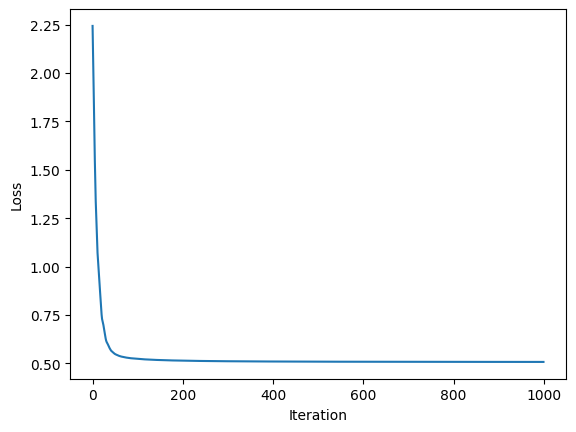

In [8]:
# plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Now let's plot the points again, colored by the labels. We expect the points with the same label to be close to each other, and we expect the groups to be equally distributed in the space:

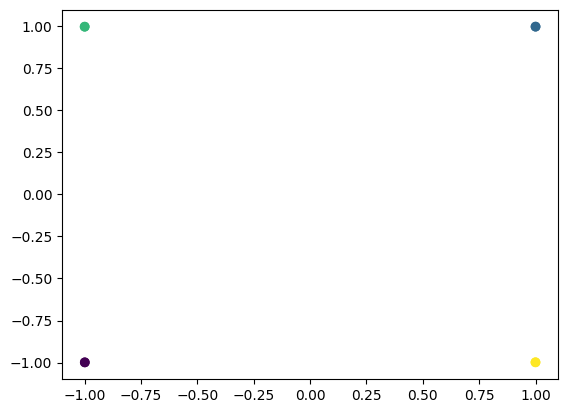

In [9]:
plot_points(z.tanh(), labels) # We use the tanh to ensure the embeddings are in the range [-1, 1]